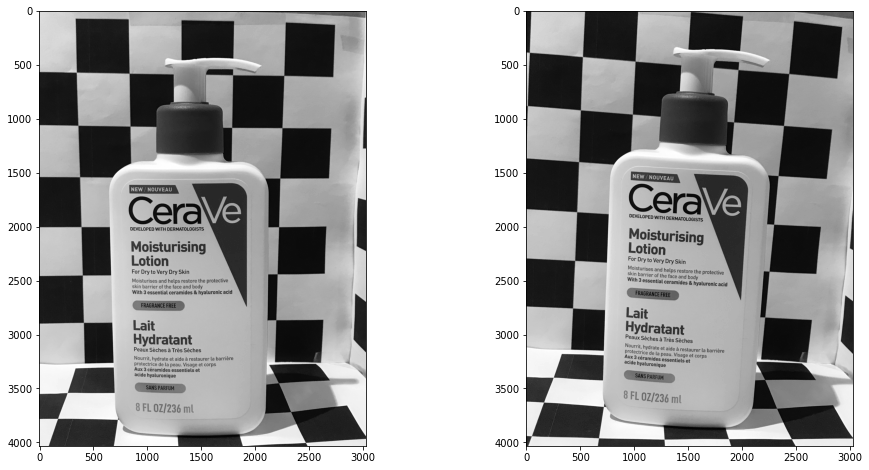

In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10

img_file1 = "./images3/1.jpg"
img_file2 = "./images3/2.jpg"
img1 = cv.imread(r'../images3/HG/1.jpg',cv.IMREAD_GRAYSCALE)           # queryImage
img2 = cv.imread(r'../images3/HG/2.jpg',cv.IMREAD_GRAYSCALE)           # trainImage

figure, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')

In [6]:
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
print("The length of detected features in image 1 is ", np.size(kp1))
print("The length of detected features in image 2 is ", np.size(kp2))

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)



The length of detected features in image 1 is  8592
The length of detected features in image 2 is  8828


In [7]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    print(M);

    print("The number of inlier points = ", np.size(src_pts))
    print("The number of outlier points of image 1 = ", np.size(kp1) - np.size(src_pts))
    print("The number of outlier points of image 2 = ", np.size(kp2) - np.size(src_pts))
    
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

[[ 1.00466269e+00 -6.27835835e-02  2.35208613e+02]
 [ 6.20998675e-02  1.00117956e+00 -1.76253952e+02]
 [ 2.29131506e-06 -5.78536983e-07  1.00000000e+00]]
The number of inlier points =  4418
The number of outlier points of image 1 =  4174
The number of outlier points of image 2 =  4410


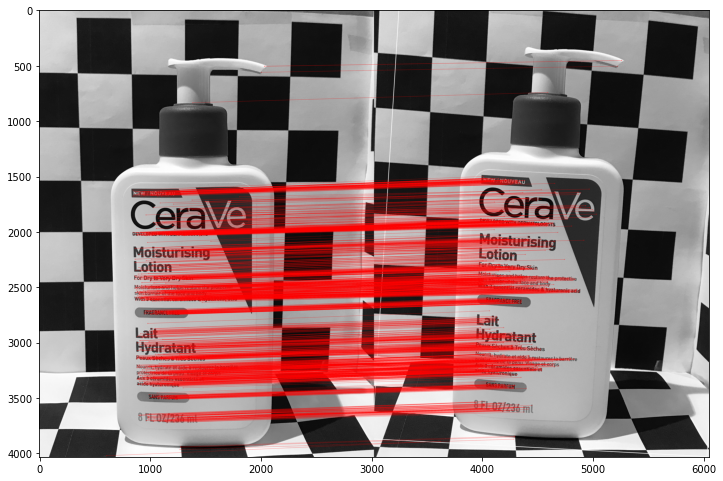

(<matplotlib.image.AxesImage at 0x2525f99a730>, None)

In [8]:
draw_params = dict(matchColor = (255,0,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(12,12))
plt.imshow(img3, 'gray'),plt.show()
# plt.imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
# plt.show